<a href="https://colab.research.google.com/github/shreyasat27/MSc-QT-/blob/main/thesis_plts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install qutip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.8/31.8 MB 58.8 MB/s eta 0:00:00


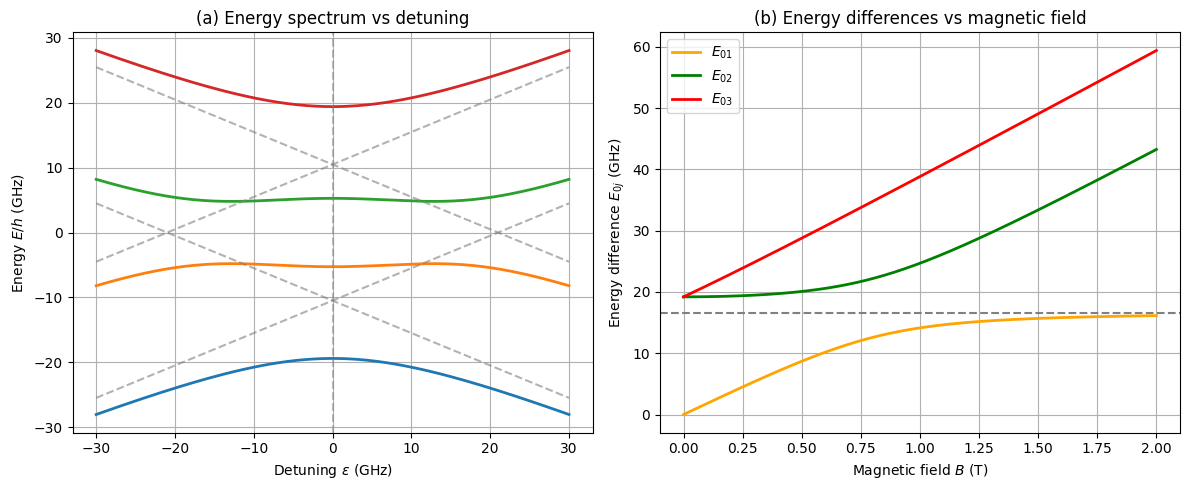

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# ---------------- Parameters ----------------
t_total = 9.6        # Total tunnel coupling (GHz)
theta = np.pi / 6    # Angle for splitting t_sc and t_sf (30°)
t_sc = t_total * np.cos(theta)  # Spin-conserving
t_sf = t_total * np.sin(theta)  # Spin-flipping

# Physical constants
muB_GHz_T = 13.99624555   # μB in GHz/T
g_factor = 1.5            # Example g-factor

def H_dqd(eps, t_sc, t_sf, B):
    """Double quantum dot Hamiltonian in basis |L↓>, |L↑>, |R↓>, |R↑>"""
    Ez = g_factor * muB_GHz_T * B   # Zeeman splitting in GHz
    H = np.array([
        [-eps/2 - Ez/2,     0,         -t_sc,      t_sf],
        [     0,      -eps/2 + Ez/2,   -t_sf,      -t_sc],
        [ -t_sc,       -t_sf,      eps/2 - Ez/2,     0  ],
        [ t_sf,       -t_sc,          0,       eps/2 + Ez/2]
    ])
    return Qobj(H)

# --------- Panel (a): Energies vs detuning ----------
eps_range = np.linspace(-30, 30, 300)  # GHz
B_fixed = 1.0   # Tesla
energies, energies_ref = [], []

for eps in eps_range:
    H = H_dqd(eps, t_sc, t_sf, B_fixed)
    energies.append(np.sort(H.eigenenergies()))

    H_ref = H_dqd(eps, 0, 0, B_fixed)
    energies_ref.append(np.sort(H_ref.eigenenergies()))

energies = np.array(energies)
energies_ref = np.array(energies_ref)

# --------- Panel (b): Energy differences vs B ----------
B_range = np.linspace(0, 2, 200)  # Tesla
E_diffs = []

for B_val in B_range:
    H = H_dqd(0, t_sc, t_sf, B_val)  # detuning = 0
    eigs = np.sort(H.eigenenergies())
    E_diffs.append([eigs[1]-eigs[0], eigs[2]-eigs[0], eigs[3]-eigs[0]])

E_diffs = np.array(E_diffs)

# --------- Plotting ----------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# (a) Energies vs detuning
for i in range(4):
    axes[0].plot(eps_range, energies[:, i], lw=2, label=f"Level {i}")
    axes[0].plot(eps_range, energies_ref[:, i], "--", color="gray", alpha=0.6)

axes[0].axvline(0, linestyle="--", color="gray", alpha=0.5)
axes[0].set_xlabel("Detuning $\\varepsilon$ (GHz)")
axes[0].set_ylabel("Energy $E/h$ (GHz)")
axes[0].set_title("(a) Energy spectrum vs detuning")
axes[0].grid(True)

# (b) Energy differences vs B
axes[1].plot(B_range, E_diffs[:,0], color="orange", lw=2, label="$E_{01}$")
axes[1].plot(B_range, E_diffs[:,1], color="green", lw=2, label="$E_{02}$")
axes[1].plot(B_range, E_diffs[:,2], color="red", lw=2, label="$E_{03}$")

axes[1].axhline(2*t_sc, ls="--", color="gray")  # reference line
axes[1].set_xlabel("Magnetic field $B$ (T)")
axes[1].set_ylabel("Energy difference $E_{0j}$ (GHz)")
axes[1].set_title("(b) Energy differences vs magnetic field")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


/usr/local/lib/python3.12/dist-packages/qutip/solver/solver_base.py:583: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


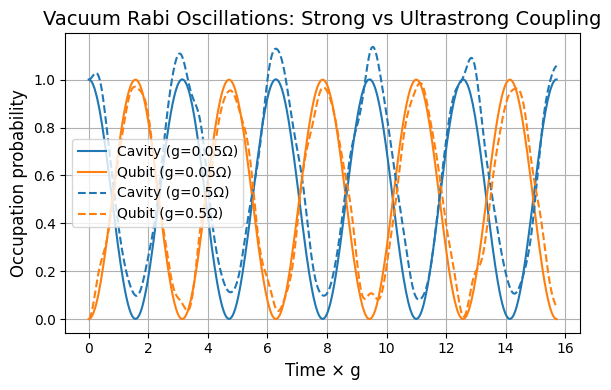

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# System constants
omega = 2 * np.pi
N = 4
theta = 0
epsilon = 2 * omega * np.sin(theta)
t_c = 1 * omega * np.cos(theta)

# Operators
a = tensor(destroy(N), qeye(2))
adag = a.dag()
sigma_x = tensor(qeye(N), Qobj([[0, 1], [1, 0]]))
sigma_z = tensor(qeye(N), Qobj([[1, 0], [0, -1]]))
idn = tensor(qeye(N), Qobj([[1, 0], [0, 1]]))

# Initial state: 1 photon in cavity, qubit in ground state
psi0 = tensor(basis(N, 1), basis(2, 0))

def simulate_dynamics(g):
    """Simulate the dynamics for a given coupling strength g."""
    tlist = np.linspace(0, 5*np.pi/g, 1000)
    H_interaction = (g * (a + adag)) * (np.sin(theta) * sigma_z + np.cos(theta) * sigma_x)
    omega_R = 2 * np.sqrt(((epsilon/2)**2) + t_c**2)
    H_res = omega_R * adag * a
    H_matrix = -np.sqrt(((epsilon/2)**2) + t_c**2) * sigma_z
    H = H_matrix + H_interaction + H_res
    c_ops = []  # no dissipation for this plot
    result = mesolve(H, psi0, tlist, c_ops, [adag * a, ((-sigma_z + idn) / 2)])
    return tlist * g, result.expect[0], result.expect[1]

# Simulate both cases
tlist_05g, cavity_05g, qubit_05g = simulate_dynamics(0.05 * omega)
tlist_5g,  cavity_5g,  qubit_5g  = simulate_dynamics(0.5  * omega)

# Plotting
fig, ax = plt.subplots(figsize=(6, 4))
# g = 0.05 omega (strong coupling, solid lines)
ax.plot(tlist_05g, cavity_05g, label="Cavity (g=0.05Ω)", color='tab:blue', linestyle='-')
ax.plot(tlist_05g, qubit_05g, label="Qubit (g=0.05Ω)", color='tab:orange', linestyle='-')
# g = 0.5 omega (ultrastrong coupling, dashed lines)
ax.plot(tlist_5g, cavity_5g, label="Cavity (g=0.5Ω)", color='tab:blue', linestyle='--')
ax.plot(tlist_5g, qubit_5g, label="Qubit (g=0.5Ω)", color='tab:orange', linestyle='--')

ax.set_xlabel("Time × g", fontsize=12)
ax.set_ylabel("Occupation probability", fontsize=12)
ax.set_title("Vacuum Rabi Oscillations: Strong vs Ultrastrong Coupling", fontsize=14)
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


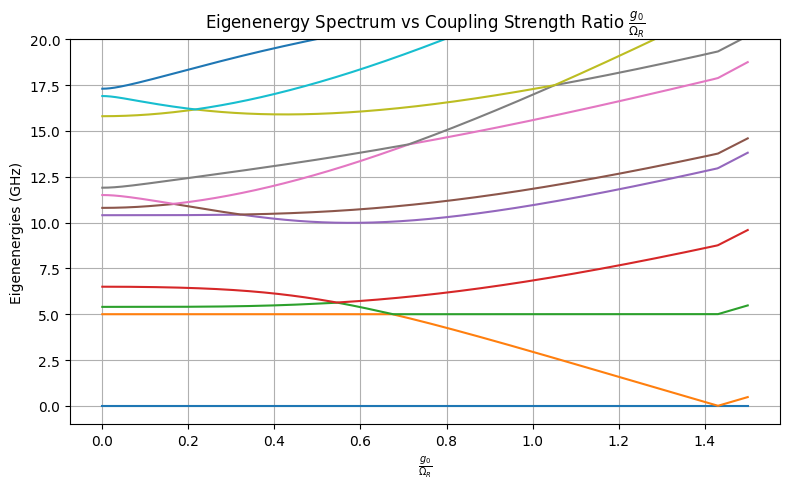

[-2.5  2.5  2.9  4.   7.9  8.3  9.   9.4 13.3 14.4 14.8 19.8]


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# ----- Parameters -----
omega_R = 5.4 * 2 * np.pi    # GHz -> rad/s
E_plus = 18 * 2 * np.pi     # GHz
E_minus = 8 * 2 * np.pi   # GHz
tunnel_coupling = 9.6 * 2 * np.pi

phi = np.pi / 4               # 45 degrees for tunneling
theta = np.pi / 4             # 45 degrees for g_a/g_b

t_sc = tunnel_coupling * np.cos(phi)
t_sf = tunnel_coupling * np.sin(phi)

# Coupling scan
g0_vals = np.linspace(0, 1.5 * omega_R, 1000)   # GHz range converted to rad/s
g_angle = np.pi / 4                            # 45 degrees

# ----- System dimensions -----
Nph = 3             # photon cutoff
Ndot = 4            # 4-level system (|L↑>, |L↓>, |R↑>, |R↓>)

# Operators on dot+spin system
I4 = qeye(Ndot)
a = destroy(Nph)
adag = a.dag()
Iph = qeye(Nph)

# Define the system states in this order:
# |L↑>, |L↓>, |R↑>, |R↓>
# Define Pauli-like ops for spin (σ) and dot (τ)
# Custom matrices for 4-level space (manually construct):

# σ_z acts on spin up/down
sigma_z = Qobj(np.diag([1, -1, 1, -1]))
sigma_p = Qobj([[0, 1, 0, 0],
                [0, 0, 0, 0],
                [0, 0, 0, 1],
                [0, 0, 0, 0]])
sigma_m = sigma_p.dag()

# τ_z acts on L/R
tau_z = Qobj([[1, 0, -1, 0],
              [0, 1, 0, -1],
              [-1, 0, 1, 0],
              [0, -1, 0, 1]]) / 2

tau_p = Qobj([[0, 0, 1, 0],
              [0, 0, 0, 1],
              [0, 0, 0, 0],
              [0, 0, 0, 0]])
tau_m = tau_p.dag()

tau_x = tau_p + tau_m

# Tensor to total Hilbert space
def tensor_op(dot_op, ph_op):
    return tensor(dot_op, ph_op)

# Hamiltonian H_0
H0 = tensor_op(I4, omega_R * adag * a) \
     + tensor_op((E_plus + E_minus)/4 * tau_z, Iph) \
     + tensor_op((E_plus - E_minus)/4 * sigma_z, Iph)

# Storage for eigenenergies
eigenvals = []


# Sweep over g0
for g0 in g0_vals:
    g_a = g0 * np.cos(g_angle)
    g_b = g0 * np.sin(g_angle)

    # Interaction Hamiltonians
    H1 = g_a * (tensor_op(tau_z * sigma_p, a) + tensor_op(tau_z * sigma_m, adag)) \
       + g_b * (tensor_op(tau_p, a) + tensor_op(tau_m, adag))

    H2 = g_a * (tensor_op(tau_z * sigma_m, a) + tensor_op(tau_z * sigma_p, adag)) \
       + g_b * (tensor_op(tau_m, a) + tensor_op(tau_p, adag))

    H = H0 + H1 + H2

    evals = H.eigenenergies()
    eigenvals.append(evals[:16])

# Convert to numpy array for plotting
eigenvals = np.array(eigenvals)


# ----- Plotting -----
plt.figure(figsize=(8, 5))
for i in range(eigenvals.shape[1]):
    plt.plot(g0_vals / omega_R, eigenvals[:, i] / (2*np.pi)-eigenvals[:, 0] / (2*np.pi), label=f'Level {i+1}')


plt.title(r"Eigenenergy Spectrum vs Coupling Strength Ratio $\frac{g_0}{\Omega_R}$")
plt.xlabel(r'$\frac{g_0}{\Omega_R}$')
plt.ylabel('Eigenenergies (GHz)')
plt.ylim(-1,20)
plt.grid(True)
plt.tight_layout()
plt.show()
print(np.round(eigenvals[0] / (2*np.pi), 6))

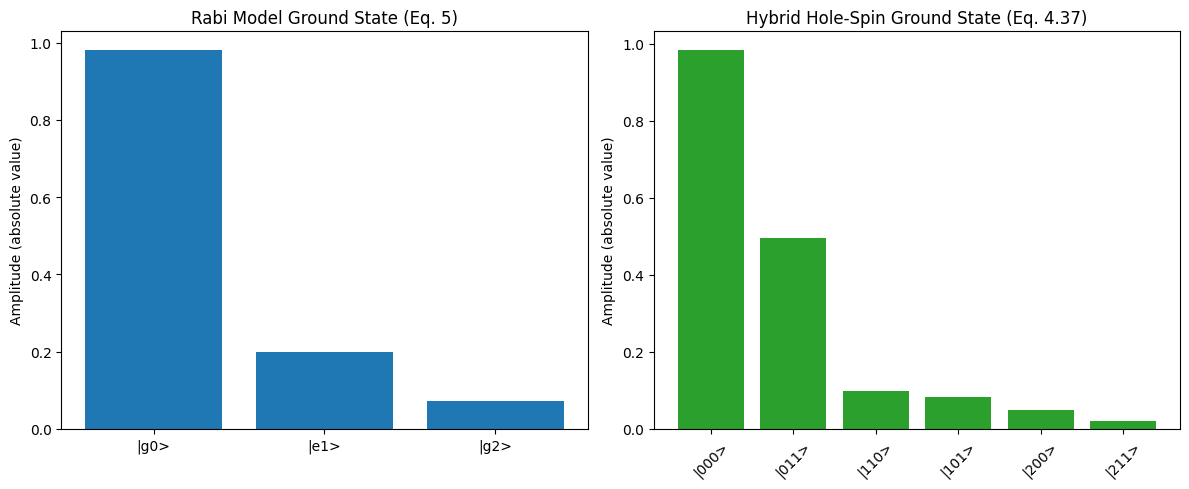

In [ ]:
# Install dependencies (matplotlib, numpy are usually pre-installed in Colab)
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1. Define Rabi-model ground state (Eq. 5)
# -----------------------------

# Parameters for the perturbative USC expansion
Lambda = 0.2   # Bloch-Siegert mixing parameter (example value)
xi = 0.05      # squeezing parameter (example value)

# State labels and coefficients
rabi_states = ["|g0>", "|e1>", "|g2>"]
rabi_coeffs = [
    1 - Lambda**2/2,   # vacuum correction
    -Lambda,           # single excitation
    xi * np.sqrt(2)    # two-photon admixture
]

# -----------------------------
# 2. Define hybrid system ground state (Eq. 4.37 approx)
# -----------------------------

# Example parameters (choose small to mimic perturbative regime)
c0 = 1.0
c2 = 0.05
delta = 0.1
delta_p = 0.08

# State labels in your notation
hybrid_states = ["|000>", "|011>", "|110>", "|101>", "|200>", "|211>"]

# Approximate coefficients, simplified from Eq. 4.37
hybrid_coeffs = [
    c0 - c0*(delta**2 + delta_p**2),                  # vacuum
    -(c0 * 0.5 - c0*delta*delta_p/2),                 # |011>
    -(c0*delta - c2*0.5*delta_p/np.sqrt(2)),          # |110>
    +(c0*delta_p + c2*0.5*delta/np.sqrt(2)),          # |101>
    c2,                                               # |200>
    -(c2*0.5 - c0*delta*delta_p/np.sqrt(2))           # |211>
]

# -----------------------------
# 3. Plotting
# -----------------------------

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot Rabi model amplitudes
axes[0].bar(rabi_states, np.abs(rabi_coeffs), color="tab:blue")
axes[0].set_title("Rabi Model Ground State (Eq. 5)")
axes[0].set_ylabel("Amplitude (absolute value)")

# Plot Hybrid system amplitudes
axes[1].bar(hybrid_states, np.abs(hybrid_coeffs), color="tab:green")
axes[1].set_title("Hybrid Hole-Spin Ground State (Eq. 4.37)")
axes[1].set_ylabel("Amplitude (absolute value)")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


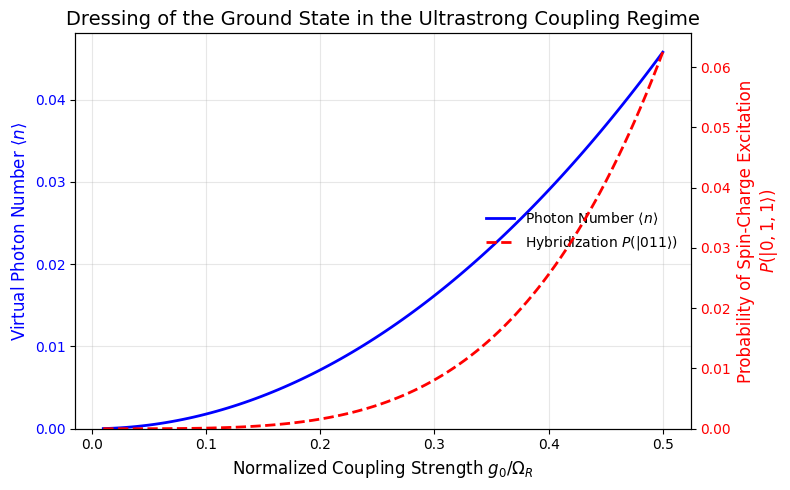

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Define the system parameters (from Fig 3.1 in the thesis)
Omega_R = 5.4  # GHz
E_plus = 18.0  # GHz
E_minus = 8.0  # GHz
phi_diff = np.pi / 4  # radians -> ga = g0*sin(pi/4), gb = g0*cos(pi/4)

# Define the small parameters delta (δ) and delta_prime (δ')
def calculate_delta(g0):
    ga = g0 * np.sin(phi_diff)
    return (2 * ga) / (E_minus - E_plus - 2 * Omega_R)

def calculate_delta_prime(g0):
    gb = g0 * np.cos(phi_diff)
    return (-2 * gb) / (E_minus + E_plus + 2 * Omega_R)

# Define the squeezing parameter r and coefficients c0, c2
# We use a simplified model for the squeezing parameter for the plot.
# A full calculation would use λ_3a and λ_3b, but the quadratic trend is key.
def calculate_squeezing(g0):
    # The squeezing parameter is proportional to g0^2.
    # We model it as r = -α * g0^2, capturing the leading order effect.
    alpha = 1 / (Omega_R * (E_plus + E_minus + 2 * Omega_R)) # Representative scale
    r = -alpha * (g0**2)
    c0 = 1 / np.sqrt(np.cosh(np.abs(r)))
    c2 = -np.tanh(np.abs(r)) / (np.sqrt(2) * np.cosh(np.abs(r)))
    return c0, c2

# Perturbative calculation of the expectation value for photon number <n>
def calculate_photon_number(g0):
    delta_val = calculate_delta(g0)
    delta_p_val = calculate_delta_prime(g0)
    c0, c2 = calculate_squeezing(g0)

    # <n> = <GS|a⁺a|GS>
    # The main contributions are:
    # 1. The |200> term (from squeezing V1): has 2 photons -> weight |c2|^2 * 2
    # 2. The |110> term: has 1 photon -> weight |c0 * δ|^2 * 1
    # 3. The |101> term: has 1 photon -> weight |c0 * δ'|^2 * 1
    # 4. The |211> term is higher order and we neglect it for this plot.
    n_expectation = (2 * np.abs(c2)**2) + (1 * np.abs(c0 * delta_val)**2) + (1 * np.abs(c0 * delta_p_val)**2)

    return n_expectation

# Perturbative calculation of the spin-charge hybridization
# We use a simplified measure: the probability to be in the |0,1,1> state
# (which is a spin-charge excited state) is a good indicator of hybridization.
def calculate_hybridization(g0):
    delta_val = calculate_delta(g0)
    delta_p_val = calculate_delta_prime(g0)
    c0, c2 = calculate_squeezing(g0)

    # The amplitude for |0,1,1> is approximately: a_011 = (c0/2)*δ*δ' - (c0/2)*φ_+(1/2)
    # Since φ_+(1/2) is also ~ g0^2, we model the whole term as proportional to g0^2.
    # The probability is |a_011|^2 ~ (g0^4). We use a simple quadratic model for visualization.
    p_011 = (g0 / Omega_R)**4 # Representative scaling

    return p_011

# Range of coupling strengths
g0_over_Omega = np.linspace(0.01, 0.5, 100)  # g0/Ω_R from 0.01 to 0.5
g0_values = g0_over_Omega * Omega_R

# Calculate the data
n_photons = []
hybridization = []
for g0 in g0_values:
    n_photons.append(calculate_photon_number(g0))
    hybridization.append(calculate_hybridization(g0))

# Create the plot
plt.figure(figsize=(8, 5))
ax1 = plt.gca()
ax2 = ax1.twinx()

# Plot Photon Number
ln1 = ax1.plot(g0_over_Omega, n_photons, 'b-', label='Photon Number $\\langle n \\rangle$', linewidth=2)
ax1.set_xlabel('Normalized Coupling Strength $g_0 / \\Omega_R$', fontsize=12)
ax1.set_ylabel('Virtual Photon Number $\\langle n \\rangle$', color='b', fontsize=12)
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_ylim(bottom=0) # Start at zero

# Plot Hybridization
ln2 = ax2.plot(g0_over_Omega, hybridization, 'r--', label='Hybridization $P(|011\\rangle)$', linewidth=2)
ax2.set_ylabel('Probability of Spin-Charge Excitation\n$P(|0,1,1\\rangle)$', color='r', fontsize=12)
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_ylim(bottom=0) # Start at zero

# Add a legend
lines = ln1 + ln2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='center right', frameon=False)

# Add title and grid
plt.title('Dressing of the Ground State in the Ultrastrong Coupling Regime', fontsize=14)
ax1.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()